# Physiscs Informed Neural Network of Position and Velocity

This notebook demonstrates how to estimate the position and velocity of an object using a Physics Informed Neural Network (PINN) using the `torch` library.

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output
import numpy as np

In [2]:
class FCN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[nn.Linear(N_INPUT, N_HIDDEN), activation()])
        self.fch = nn.Sequential(*[
            nn.Sequential(*[
                nn.Linear(N_HIDDEN, N_HIDDEN),
                activation()]) for _ in range(N_LAYERS)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [3]:
# Load the exprimental data from the repository
data_url = 'https://raw.githubusercontent.com/jsuarez314/bayesian-ml-physics-lab/refs/heads/main/data/U1.txt'
!wget -nc {data_url}
pathfile = 'U1.txt'
data = np.loadtxt(pathfile)

File ‘U1.txt’ already there; not retrieving.



### Position PINN model

In this approach, the **Physics-Informed Neural Network (PINN)** is used to model the position of the oscillating fluid in the U-tube system.  
Unlike the analytical or Bayesian models, the PINN does not assume a predefined functional form for the motion.  
Instead, it learns both the governing dynamics and the physical parameters directly from the data by minimizing a composite loss function that combines data fidelity and physical consistency.

The network architecture consists of a fully connected neural network (FCN) that takes time $t$ as input and outputs the corresponding displacement $x(t)$.  
Two physical parameters, the damping coefficient $\mu$ and the natural angular frequency $\omega_0$, are treated as **trainable parameters** during optimization, allowing the network to infer them from experimental data.

The PINN is trained by minimizing the following total loss function:

$$
\mathscr{L}_{\text{total}} = \lambda_{\text{data}} \, \mathscr{L}_{\text{data}} + \lambda_{\text{physics}} \, \mathscr{L}_{\text{physics}},$$

where:

- $ \mathscr{L}_{\text{data}} $ is the **data loss**, defined as the mean squared error (MSE) between the measured displacements $x_i$  and the network's predictions $\hat{x}_i $.
- $ \mathscr{L}_{\text{physics}} $ is the **physics loss**, enforcing the differential equation that governs the damped oscillation:

$$ \frac{d^2x}{dt^2} + \mu \frac{dx}{dt} + \omega_0^2 x = 0.$$

The weighting coefficients $ \lambda_{\text{data}} $ and $ \lambda_{\text{physics}} $ control the relative influence of the experimental data and the physical constraint, respectively.  
During training, the model adaptively adjusts both the neural network weights and the physical parameters ($\mu $, $\omega_0 $) to minimize the total loss.

This framework allows the PINN to **learn a physically consistent representation of the oscillatory motion**, even with limited or noisy data.  

By comparing the predicted displacement with the experimental measurements, the PINN effectively reconstructs the fluid's motion and identifies the underlying physical parameters, merging data-driven learning with the principles of classical mechanics.

Learning rate: 0.0002
Data: 226
Step 100000: Loss = 7.776304244995117, Mu = 0.7689899206161499, w0 = 9.724360466003418


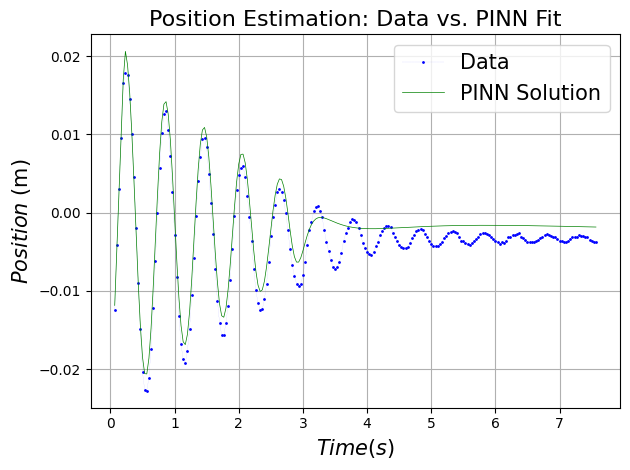

In [4]:
# Initialize empty lists to store the evolution of learned parameters
# These lists will record how mu and w0 change during training
mu_param = []
w0_param = []

# Set a random seed for reproducibility
torch.manual_seed(123)

# Define the trainable physical parameters as torch.nn.Parameters
# mu represents the damping coefficient (viscous term)
# w0 represents the natural angular frequency of the system
mu = torch.nn.Parameter(torch.tensor([0.5], requires_grad=True))
w0 = torch.nn.Parameter(torch.tensor([9.], requires_grad=True))

# Define the Physics-Informed Neural Network (PINN)
# The FCN (Fully Connected Network) takes one input (time)
# and outputs one value (position), with 70 neurons per layer and 7 layers total
pinn = FCN(1, 1, 70, 7)

# Define the optimizer (Adam) to train both the neural network and physical parameters
# mu and w0 are included in the optimization process
optimiser = torch.optim.Adam(list(pinn.parameters()) + [mu, w0], lr=1e-3)

# Define weighting coefficients for the total loss
# lambda_physics controls the relative importance of the physics constraint
# lambda_data controls the importance of matching experimental data
lambda_physics = 1e2
lambda_data = 1e6  # This can be adjusted depending on the data quality and model behavior

# Define the number of collocation points for the physics-based loss
N = 69


# Extract time (t) and position (x) from the dataset
t = data[:, 0]
x = data[:, 1]

# Convert data to PyTorch tensors and ensure correct shape
t = torch.tensor(t).float().view(-1, 1)
x = torch.tensor(x).float().view(-1, 1)


# Main training loop — run for 100,001 iterations
for i in range(100001):

    # Reset gradients from the previous iteration
    optimiser.zero_grad()

    # --- PHYSICS LOSS CALCULATION ---

    # Generate a uniformly spaced set of collocation points for the physical constraint
    t_physics = torch.linspace(t[0].item(), t[-1].item(), N).view(-1, 1).requires_grad_(True)
    t_test = torch.linspace(t[0].item(), t[-1].item(), N).view(-1, 1)

    # Predict the network output (displacement) at collocation points
    x_physics = pinn(t_physics)

    # Compute first and second derivatives of x with respect to time using automatic differentiation
    dxdt = torch.autograd.grad(x_physics, t_physics, torch.ones_like(x_physics), create_graph=True)[0]
    d2xdt2 = torch.autograd.grad(dxdt, t_physics, torch.ones_like(dxdt), create_graph=True)[0]

    # Define the physics-based loss using the equation of motion:
    # x'' + mu * x' + w0² * x = 0
    # The loss measures how well the network output satisfies this differential equation
    loss_physics = torch.mean((d2xdt2 + mu * dxdt + (w0 ** 2) * x_physics) ** 2)

    # --- DATA LOSS CALCULATION ---

    # Predict network output for the experimental data points
    xpinn = pinn(t)

    # Compute the mean squared error between predicted and observed positions
    loss_data = torch.mean((xpinn - x) ** 2)

    # --- TOTAL LOSS ---

    # Combine data and physics losses using weighting coefficients
    loss = lambda_physics * loss_physics + lambda_data * loss_data

    # Compute gradients of the total loss with respect to all trainable parameters
    loss.backward()

    # --- DYNAMIC TRAINING ADJUSTMENTS ---

    # Gradually increase N (collocation points) if the loss drops below 10
    if loss.item() < 10 and N < data.shape[0]:
        N += 1

    # Adaptively reduce the learning rate as the model converges
    if loss.item() < 100:
        for param_group in optimiser.param_groups:
            param_group['lr'] = 6e-4

    if loss.item() < 20:
        for param_group in optimiser.param_groups:
            param_group['lr'] = 2e-4

    if loss.item() < 1:
        for param_group in optimiser.param_groups:
            param_group['lr'] = 1e-5

    # Perform an optimization step (update network and physical parameters)
    optimiser.step()

    # Record the current values of the physical parameters
    mu_param.append(mu.item())
    w0_param.append(w0.item())

    # --- VISUALIZATION AND TRAINING LOG ---

    # Every 100 iterations, print progress and plot results
    if i % 100 == 0:

        clear_output(wait=True)

        # Print the current learning rate
        for param_group in optimiser.param_groups:
            print("Learning rate:", param_group['lr'])

        # Display training step, number of collocation points, loss, and learned parameters
        print('Data:', N)
        print(f"Step {i}: Loss = {loss.item()}, Mu = {mu.item()}, w0 = {w0.item()}")

        # Predict the solution for visualization
        u_test = pinn(t_test).detach()

        # Plot experimental data and model prediction
        plt.plot(t, x, color='blue', label='Data', marker='.', markersize=2.0, linewidth=0.05, ls='--')
        plt.plot(t_test[:, 0], u_test[:, 0], color='green', linewidth=0.5, label='PINN Solution')  # Model output
        plt.xlabel(r'$Time (s)$', fontsize=15)
        plt.ylabel(r'$Position$ (m)', fontsize=15)
        plt.title('Position Estimation: Data vs. PINN Fit', fontsize=16)
        plt.grid(True)
        plt.legend(fontsize=15)
        plt.tight_layout()
        plt.show()

The following plot serves as a visual diagnostic, showing how the trainable physical parameters of the Physics-Informed Neural Network (PINN) (the damping coefficient $\mu$ and the natural angular frequency $\omega_0$) evolve throughout the training process. By tracking these values over iterations, one can monitor convergence and assess whether the PINN is learning physically meaningful parameters that are consistent with both the experimental data and the governing differential equation.

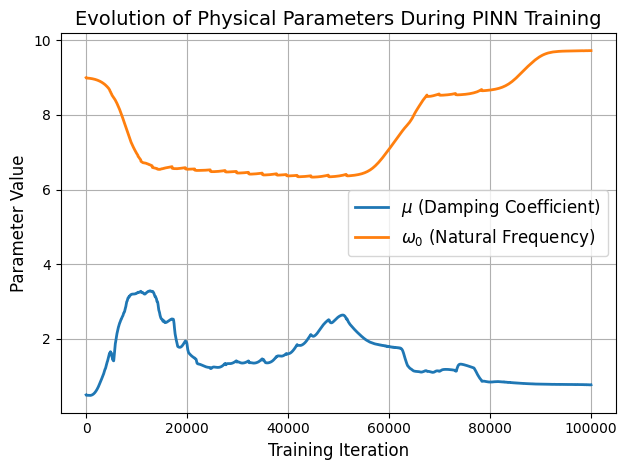

In [5]:
# Plot the evolution of the damping coefficient 'mu' during training
plt.plot(mu_param, label=r'$\mu$ (Damping Coefficient)', color='tab:blue', linewidth=2)

# Plot the evolution of the natural angular frequency 'w0' during training
plt.plot(w0_param, label=r'$\omega_0$ (Natural Frequency)', color='tab:orange', linewidth=2)

plt.title('Evolution of Physical Parameters During PINN Training', fontsize=14)
plt.xlabel('Training Iteration', fontsize=12)
plt.ylabel('Parameter Value', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

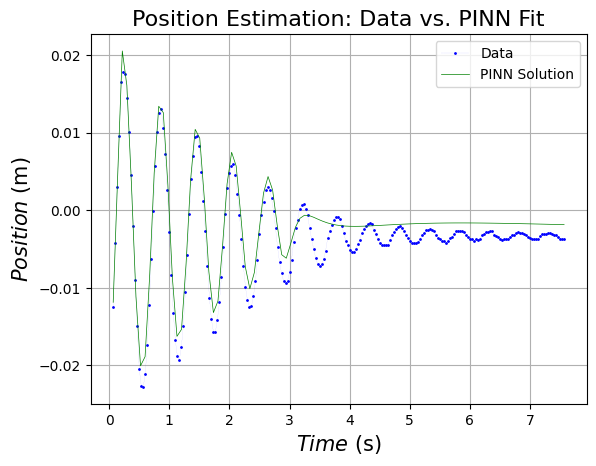

In [6]:
## --- Final Position Model ---
# Extract the full time (t) and position (x) data from the dataset
# These represent the observed experimental measurements
t = data[:, 0]
x = data[:, 1]

# Convert the NumPy arrays into PyTorch tensors for model evaluation
# The .view(-1, 1) ensures they are column vectors (Nx1) as expected by the network
t = torch.tensor(t).float().view(-1, 1)
x = torch.tensor(x).float().view(-1, 1)

# Generate a uniform grid of 100 time points covering the full observation range
# These points will be used to evaluate the trained PINN model continuously
t_test = torch.linspace(t[0].item(), t[-1].item(), 100).view(-1, 1)

# Use the trained PINN to predict the displacement at the test time points
x_test = pinn(t_test).detach()


# Plot the experimental data as red points

# These represent the real observed motion of the fluid column
plt.plot(t, x, color='blue', label='Data', marker='.', markersize=2.0, linewidth=0.05, ls='--')

# Plot the PINN prediction as a green continuous curve
# This shows the model’s learned representation of the oscillatory behavior
plt.plot(t_test[:, 0], x_test[:, 0], color='green', linewidth=0.5, label='PINN Solution')

# Add axis labels for time and displacement
plt.xlabel(r'$Time$ (s)', fontsize=15)
plt.ylabel(r'$Position$ (m)', fontsize=15)
plt.title('Position Estimation: Data vs. PINN Fit', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

### Velocity PINN model

In this approach, the **Physics-Informed Neural Network (PINN)** is used to model the **velocity** of the oscillating fluid in the U-tube system.  
Unlike analytical or Bayesian models, the PINN does not assume a predefined functional form for the velocity.  
Instead, it learns both the dynamics and the physical parameters directly from the data by minimizing a composite loss function that combines data fidelity and physical consistency.

The network architecture consists of a fully connected neural network (FCN) that takes time $t$ as input and outputs the corresponding velocity $v(t)$.  
Two physical parameters, the damping coefficient $\mu$ and the natural angular frequency $\omega_0$, are treated as **trainable parameters** during optimization, allowing the network to infer them from experimental velocity data.

The PINN is trained by minimizing the following total loss function:

$$
\mathscr{L}_{\text{total}} = \lambda_{\text{data}} \, \mathscr{L}_{\text{data}} + \lambda_{\text{physics}} \, \mathscr{L}_{\text{physics}},
$$

where:

- $\mathscr{L}_{\text{data}}$ is the **data loss**, defined as the mean squared error (MSE) between the measured velocities $v_i$ and the network's predictions $\hat{v}_i$.  
- $ \mathscr{L}_{\text{physics}} $ is the **physics loss**, enforcing the differential equation that governs the damped oscillation:

$$\frac{d^2v}{dt^2} + \mu \frac{dv}{dt} + \omega_0^2 v = 0.$$

The weighting coefficients $\lambda_{\text{data}}$ and $\lambda_{\text{physics}}$ control the relative influence of the experimental data and the physical constraint, respectively.  
During training, the model adaptively adjusts both the neural network weights and the physical parameters ($\mu, \omega_0$) to minimize the total loss.

This framework allows the PINN to **learn a physically consistent representation of the velocity profile**, even with limited or noisy measurements.  

By comparing the predicted velocity with the experimental data, the PINN effectively reconstructs the fluid's motion in terms of its rate of change and identifies the underlying physical parameters, merging data-driven learning with the principles of classical mechanics.

Learning rate: 0.0006
Data: 69
Step 100000: Loss = 25.599584579467773, Mu = 1.0982985496520996, w0 = 10.562417030334473


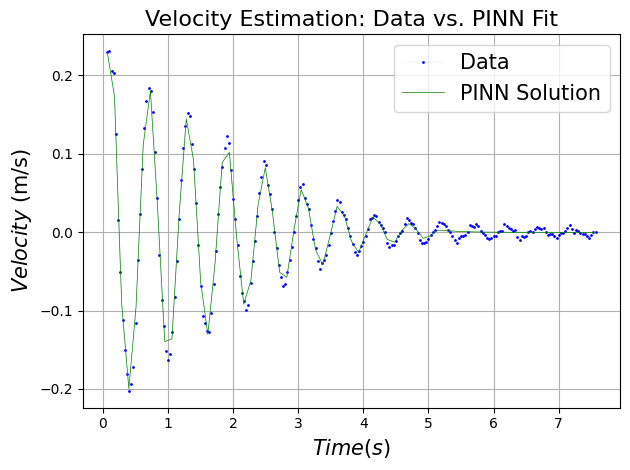

In [7]:
# Initialize empty lists to store the evolution of learned physical parameters
mu_param = []  # Damping coefficient
w0_param = []  # Natural angular frequency

# Set random seed for reproducibility
torch.manual_seed(123)

# Define trainable physical parameters
# mu: damping coefficient
# w0: natural angular frequency
mu = torch.nn.Parameter(torch.tensor([0.5], requires_grad=True))
w0 = torch.nn.Parameter(torch.tensor([9.0], requires_grad=True))

# Define the Physics-Informed Neural Network (PINN)
# The FCN takes time as input and outputs velocity
pinn = FCN(1, 1, 70, 7)

# Define the optimizer to train both network and physical parameters
optimiser = torch.optim.Adam(list(pinn.parameters()) + [mu, w0], lr=1e-3)

# Define weighting coefficients for loss
lambda_physics = 1e2  # Importance of physics constraint
lambda_data = 1e6     # Importance of matching experimental data

# Number of collocation points for physics-based loss
N = 69

# Extract time (t) and velocity (v) from dataset
t = data[:, 0]
v = data[:, 2]  # Velocity measurements

# Convert to PyTorch tensors with correct shape
t = torch.tensor(t).float().view(-1, 1)
v = torch.tensor(v).float().view(-1, 1)

# Main training loop
for i in range(100001):

    # Reset gradients
    optimiser.zero_grad()

    # --- PHYSICS LOSS ---

    # Collocation points for enforcing physics
    t_physics = torch.linspace(t[0].item(), t[-1].item(), N).view(-1, 1).requires_grad_(True)
    t_test = torch.linspace(t[0].item(), t[-1].item(), N).view(-1, 1)

    # Predict velocity at collocation points
    v_physics = pinn(t_physics)

    # Compute derivatives: dv/dt and d²v/dt²
    dvdt = torch.autograd.grad(v_physics, t_physics, torch.ones_like(v_physics), create_graph=True)[0]
    d2vdt2 = torch.autograd.grad(dvdt, t_physics, torch.ones_like(dvdt), create_graph=True)[0]

    # Physics-based loss: v'' + mu*v' + w0²*v = 0
    loss_physics = torch.mean((d2vdt2 + mu * dvdt + (w0 ** 2) * v_physics) ** 2)

    # --- DATA LOSS ---

    # Predicted velocity at experimental time points
    vpinn = pinn(t)

    # Mean squared error between predicted and measured velocity
    loss_data = torch.mean((vpinn - v) ** 2)

    # --- TOTAL LOSS ---

    loss = lambda_physics * loss_physics + lambda_data * loss_data

    # Backpropagation
    loss.backward()

    # --- DYNAMIC TRAINING ADJUSTMENTS ---
    if loss.item() < 10 and N < data.shape[0]:
        N += 1

    if loss.item() < 100:
        for param_group in optimiser.param_groups:
            param_group['lr'] = 6e-4
    if loss.item() < 20:
        for param_group in optimiser.param_groups:
            param_group['lr'] = 2e-4
    if loss.item() < 1:
        for param_group in optimiser.param_groups:
            param_group['lr'] = 1e-5

    # Update network and physical parameters
    optimiser.step()

    # Record the evolution of mu and w0
    mu_param.append(mu.item())
    w0_param.append(w0.item())

    # --- VISUALIZATION AND LOG ---
    if i % 100 == 0:
        clear_output(wait=True)

        # Print learning rate
        for param_group in optimiser.param_groups:
            print("Learning rate:", param_group['lr'])

        # Print training progress
        print('Data:', N)
        print(f"Step {i}: Loss = {loss.item()}, Mu = {mu.item()}, w0 = {w0.item()}")

        # Predict for visualization
        v_test = pinn(t_test).detach()

        # Plot experimental velocity vs PINN prediction
        plt.plot(t, v, color='blue', label='Data', marker='.', markersize=2.0, linewidth=0.05, ls='--')
        plt.plot(t_test[:, 0], v_test[:, 0], color='green', linewidth=0.5, label='PINN Solution')
        plt.xlabel(r'$Time (s)$', fontsize=15)
        plt.ylabel(r'$Velocity$ (m/s)', fontsize=15)
        plt.title('Velocity Estimation: Data vs. PINN Fit', fontsize=16)
        plt.grid(True)
        plt.legend(fontsize=15)
        plt.tight_layout()
        plt.show()

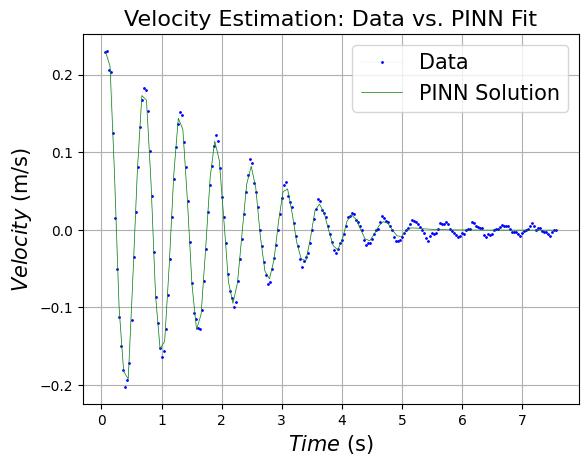

In [8]:
## --- Final Velocity Model ---
# Extract the full time (t) and velocity (v) data from the dataset
# These represent the observed experimental measurements
t = data[:, 0]
v = data[:, 2]

# Convert the NumPy arrays into PyTorch tensors for model evaluation
# The .view(-1, 1) ensures they are column vectors (Nx1) as expected by the network
t = torch.tensor(t).float().view(-1, 1)
v = torch.tensor(v).float().view(-1, 1)

# Generate a uniform grid of 100 time points covering the full observation range
# These points will be used to evaluate the trained PINN model continuously
t_test = torch.linspace(t[0].item(), t[-1].item(), 100).view(-1, 1)

# Use the trained PINN to predict the displacement at the test time points
v_test = pinn(t_test).detach()


# Plot the experimental data as red points

# These represent the real observed motion of the fluid column
plt.plot(t, v, color='blue', label='Data', marker='.', markersize=2.0, linewidth=0.05, ls='--')

# Plot the PINN prediction as a green continuous curve
# This shows the model’s learned representation of the oscillatory behavior
plt.plot(t_test[:, 0], v_test[:, 0], color='green', linewidth=0.5, label='PINN Solution')

# Add axis labels for time and displacement
plt.xlabel(r'$Time$ (s)', fontsize=15)
plt.ylabel(r'$Velocity$ (m/s)', fontsize=15)
plt.title('Velocity Estimation: Data vs. PINN Fit', fontsize=16)
plt.legend(fontsize=15)
plt.grid(True)
plt.show()

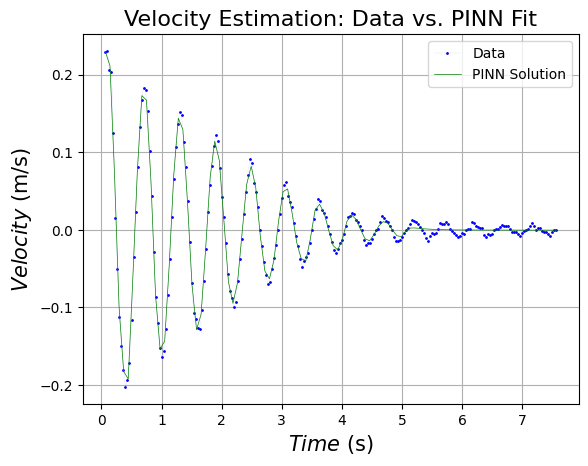

In [9]:
## --- Final Velocity Model ---
# Extract the full time (t) and velocity (v) data from the dataset
# These represent the observed experimental measurements
t = data[:, 0]
v = data[:, 2]

# Convert the NumPy arrays into PyTorch tensors for model evaluation
# The .view(-1, 1) ensures they are column vectors (Nx1) as expected by the network
t = torch.tensor(t).float().view(-1, 1)
v = torch.tensor(v).float().view(-1, 1)

# Generate a uniform grid of 100 time points covering the full observation range
# These points will be used to evaluate the trained PINN model continuously
t_test = torch.linspace(t[0].item(), t[-1].item(), 100).view(-1, 1)

# Use the trained PINN to predict the displacement at the test time points
v_test = pinn(t_test).detach()

# Plot the experimental data as red points

# These represent the real observed motion of the fluid column
plt.plot(t, v, color='blue', label='Data', marker='.', markersize=2.0, linewidth=0.05, ls='--')

# Plot the PINN prediction as a green continuous curve
# This shows the model’s learned representation of the oscillatory behavior
plt.plot(t_test[:, 0], v_test[:, 0], color='green', linewidth=0.5, label='PINN Solution')

# Add axis labels for time and displacement
plt.xlabel(r'$Time$ (s)', fontsize=15)
plt.ylabel(r'$Velocity$ (m/s)', fontsize=15)
plt.title('Velocity Estimation: Data vs. PINN Fit', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()